<a href="https://colab.research.google.com/github/HB-VM/vm/blob/master/slide_deck_template_checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Effects of Bike Hiring


## Overview

> I selected Ford GoBike dataset in order to investigate bike hiring by different people. There are a lot of different variables and our main focus is to define the most common variables which affect the bike hiring on the project.


In [0]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import math
import calendar

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [0]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('/content/mergeData.csv')

Text(0.5, 0, 'Age bike riders')

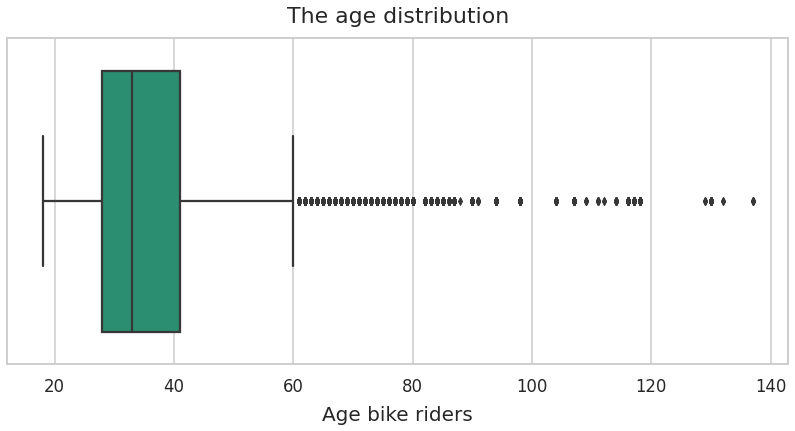

In [3]:
# Set visualization style
sns.set_style('whitegrid')
sns.set_context("talk")

# Filter data to include reasonable member age range
df['member_age'] = 2018-df['member_birth_year']

plt.figure(figsize=(14,6))
sns.boxplot(x='member_age', data=df, palette='Dark2', orient='h')
plt.title("The age distribution", fontsize=22, y=1.03)
plt.xlabel("Age bike riders", fontsize=20, labelpad=10)

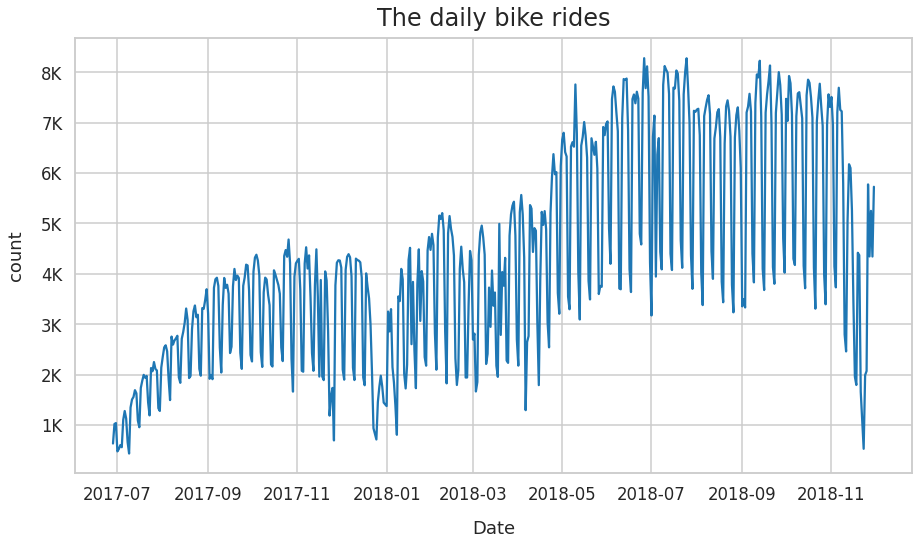

In [4]:
# Create new fields for date from start_time and end_time
df['start_time']=pd.to_datetime(df['start_time'])
df['end_time']=pd.to_datetime(df['end_time'])
df['start_time_date']=df['start_time'].dt.date
df['end_time_date']=df['end_time'].dt.date
df['start_time_year_month']=df['start_time'].map(lambda x: x.strftime('%Y-%m'))
df['end_time_year_month']=df['end_time'].map(lambda x: x.strftime('%Y-%m'))
df['start_time_year_month_renamed'] = df['start_time'].dt.strftime('%y' + '-' + '%m')
df['start_time_year']=df['start_time'].dt.year.astype(int)
df['end_time_year']=df['end_time'].dt.year.astype(int)
df['start_time_month']=df['start_time'].dt.month.astype(int)
df['end_time_month']=df['end_time'].dt.month.astype(int)
df['start_time_hour_minute']=df['start_time'].map(lambda x: x.strftime('%H-%m'))
df['end_time_hour_minute']=df['end_time'].map(lambda x: x.strftime('%H-%m'))
df['start_time_hour']=df['start_time'].dt.hour
df['end_time_hour']=df['end_time'].dt.hour
df['start_time_weekday_abbr']=df['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df['end_time_weekday_abbr']=df['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

def transform_axis(dailyBike, pos):
    if dailyBike >= 1000:
        value = int(dailyBike/1000)
        return '{:d}K'.format(value)
    elif dailyBike >= 1000000: 
        value = int(dailyBike/1000000)
        return '{:d}M'.format(value)
    else:
        return int(dailyBike)

df.groupby('start_time_date').agg({'bike_id':'count'}).plot(style='-', legend=False, figsize=(15,8))
plt.title('The daily bike rides', fontsize=24, y=1.015)
plt.xlabel('Date', labelpad=16)
plt.ylabel('count', labelpad=16)
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis))

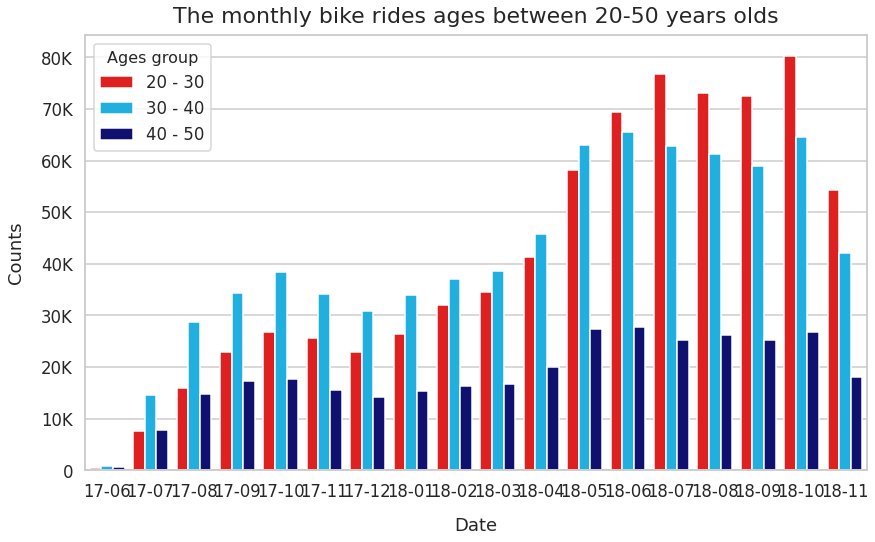

In [5]:
# Create a new field for member age group from member_age_bin
df['member_age_bins'] = df['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else x)

plt.figure(figsize=(14,8))
palette = {'20 - 30': 'red', '30 - 40': 'deepskyblue', '40 - 50': 'navy'}
axis = sns.countplot(x='start_time_year_month_renamed', hue='member_age_bins', palette=palette, data=df[df['member_age_bins'].isin(['20 - 30', '30 - 40', '40 - 50'])].sort_values(by=['start_time_year_month_renamed', 'member_age_bins']))
plt.title('The monthly bike rides ages between 20-50 years olds', fontsize=22, y=1.015)
plt.xlabel('Date', labelpad=16)
plt.ylabel('Counts', labelpad=16)
legs = axis.legend()
legs.set_title('Ages group',prop={'size':16})
axis = plt.gca()
axis.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis))

## gender of Users

(0.0, 100.0)

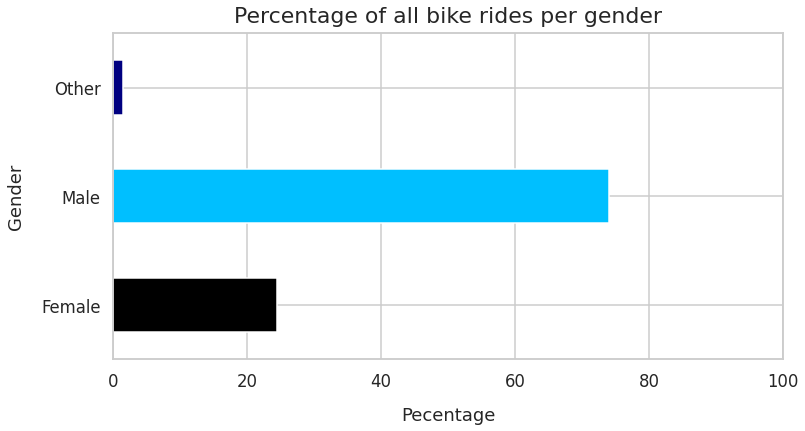

In [6]:
gender_trips = df.groupby('member_gender').agg({'bike_id':'count'})
gender_trips['perc'] = (gender_trips['bike_id']/gender_trips['bike_id'].sum())*100


colors = ['black', 'deepskyblue', 'navy']
gender_trips['perc'].plot(kind='barh', color=colors, figsize=(12,6))
plt.title('Percentage of all bike rides per gender', fontsize=22, y=1.015)
plt.ylabel('Gender', labelpad=16)
plt.xlabel('Pecentage', labelpad=16)
plt.xticks(rotation=360)
plt.xlim(0,100)


## using times of goBike

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text major ticklabel objects>)

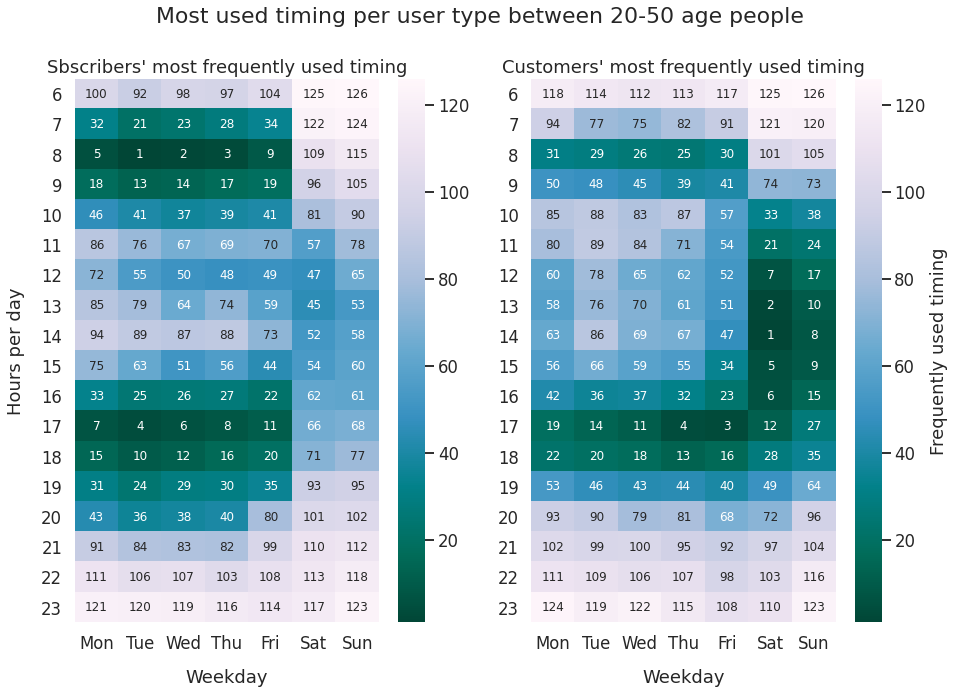

In [9]:
subscriber_hour_dataFrame = df[(df['member_age']>=20) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

subscriber_hour_dataFrame['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_dataFrame['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
subscriber_hour_dataFrame['count_perc'] = subscriber_hour_dataFrame['count'].apply(lambda x: (x/subscriber_hour_dataFrame['count'].sum())*100)
subscriber_hour_dataFrame['rank'] = subscriber_hour_dataFrame['count_perc'].rank(ascending=False).astype(int)
subscriber_hour_dataFrame_pivoted = subscriber_hour_dataFrame.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')
customer_hour_dataFrame = df[(df['member_age']>=20) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Customer') 
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()
customer_hour_dataFrame['start_time_weekday_abbr'] = pd.Categorical(customer_hour_dataFrame['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)
customer_hour_dataFrame['count_perc'] = customer_hour_dataFrame['count'].apply(lambda x: (x/customer_hour_dataFrame['count'].sum())*100) #male
customer_hour_dataFrame['rank'] = customer_hour_dataFrame['count_perc'].rank(ascending=False).astype(int)
customer_hour_dataFrame_pivoted = customer_hour_dataFrame.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank').astype(int)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.suptitle('Most used timing per user type between 20-50 age people', fontsize=22)
sns.heatmap(subscriber_hour_dataFrame_pivoted, fmt='d', annot=True, cmap='PuBuGn_r', annot_kws={"size": 12})
plt.title("Sbscribers' most frequently used timing", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hours per day', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(122)
sns.heatmap(customer_hour_dataFrame_pivoted, fmt='d', annot=True, cmap='PuBuGn_r', annot_kws={"size": 12}, cbar_kws={'label': 'Frequently used timing'})
plt.title("Customers' most frequently used timing", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)


## Conclusion

> In This ,There have been 3.31 billion rides. 20-30 years previous users ar speedily growing compared to alternative user teams. once the service 1st started 30-40 years previous users were dominant, but 20-30 years previous users became a frontrunner during a year. 20 to 40 years previous individuals took the quite p of motorbike rides. Among those, 30 to 40 years previous people's rides account almost of all bike rides. Male took around %76 of all bike rides, and female took around %24 of them. People use this service on weekdays quite weekends. 8 am and 5 pm ar the peak hours for this service. Also, individuals use this service once they are in mealtime similarly. Percentage of subscribers is almost %88.15. Percentage of customers is almost %11.85. Customers' rides appear increasing slightly however subscribers' rides reached 6 times more than customers' on Oct 2018. there's a decrease in Nov 2018 for subscribers however it feels like it's connected with the winter season. Subscribers' average trip length is around 11 minute. Customers' average trip length is around 28 minutes.